## Log in to Huggingface

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 !huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `shawnhw3` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `shawnhw3`

In [4]:
!huggingface-cli whoami

shawb2


## Installations and imports

Install the necessary libraries, then import the installed packages.

In [7]:
!pip install lambeq
!pip install discopy
!pip install rouge-score
!pip install pytket pytket-qiskit
!pip install transformers accelerate bitsandbytes

In [8]:
import random
import statistics
from pytket import Qubit
from rouge_score import rouge_scorer
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils.operators import QubitPauliOperator
from lambeq import AtomicType, BobcatParser, IQPAnsatz
from nltk.translate.bleu_score import modified_precision
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import numpy as np
from pytket import Circuit
from pytket.utils import QubitPauliOperator
from pytket.circuit import Qubit
import logging


## Setup the Large Language Model

Download and install the Llama 2 model. This step may take several minutes to complete.

In [9]:
# From the Llama-2 Chat Tutorial
# https://colab.research.google.com/drive/1X1z9Q6domMKl2CnEM0QGHNwidLfR4dW2?usp=sharing#scrollTo=THqfvzHIjSK9

model_name = "meta-llama/Llama-2-7b-chat-hf"
quantization_config = BitsAndBytesConfig(load_in_4bit=True) # https://discuss.huggingface.co/t/correct-usage-of-bitsandbytesconfig/33809
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:809: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Define Validation Functions

First, get the lambeq model for the quantum validation function. Also define variables needed for the quantum model.

In [10]:
lambeqParser = BobcatParser()
N = AtomicType.NOUN
S = AtomicType.SENTENCE
quantumAnsatz = IQPAnsatz({N: 1, S: 1}, n_layers=4)
quantumBackend = AerBackend()
parameterValue = 0.25

Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


Then define the helper functions for the lambeq quantum validator.

In [14]:
!pip install --upgrade pytket

In [50]:
def generateQuantumCircuit(sentence, draw):
  diagram = lambeqParser.sentence2diagram(sentence)
  circuit = quantumAnsatz(diagram)
  tketCircuit = circuit.to_tk()
  parameters = dict.fromkeys(tketCircuit.free_symbols(), parameterValue)
  tketCircuit.symbol_substitution(parameters)
  compiledCircuit = quantumBackend.get_compiled_circuit(tketCircuit)
  if draw:
    diagram.draw()
    render_circuit_jupyter(tketCircuit)
  return compiledCircuit

def generateZObservable(circuit):
    try:
        n = circuit.n_qubits
        observableString = QubitPauliString({Qubit(i): Pauli.Z for i in range(n)})
        observable = QubitPauliOperator({observableString: 1.0})
        return observable
    except AttributeError:
        logging.error("The input is not a valid.", exc_info=True)
        return None

def similarity(exp1, exp2, method='cosine'):
    try:
        logging.info(f"Calculating similarity using method: {method}")
        if method == 'fidelity':
            # Quantum fidelity similarity measure
            similarity = np.sum((np.sqrt(exp1) * np.sqrt(exp2)) ** 2)
        elif method == 'cosine':
            # Cosine similarity
            similarity = np.dot(exp1, exp2) / (np.linalg.norm(exp1) * np.linalg.norm(exp2))
        else:
            raise ValueError(f"Not in list: {method}")

        logging.info(f"Calculated similarity: {similarity}")
        return similarity

    except Exception as e:
        logging.error("Error occurred during calculation.", exc_info=True)
        return None

Finally, define functions to compute the BLUE, ROUGE, and LAMBEQ similarity scores between the target and hypothesis.

In [57]:

def BLEU(target, hypothesis, n=1):
  scores = []
  for i in range(len(target.split())):
    scores.append(float(modified_precision(target.split(' ')[i], hypothesis.split(' ')[i], n)))
  return statistics.mean(scores)

def ROUGE(target, hypothesis, n="L"):
  scorer = rouge_scorer.RougeScorer([f'rouge{n}'], use_stemmer=True)
  scores = scorer.score(target, hypothesis)
  return scores[f'rouge{n}'].fmeasure

def LAMBEQ(target, hypothesis, draw=False):
  tCirc = generateQuantumCircuit(target, draw)
  hCirc = generateQuantumCircuit(hypothesis, draw)
  tOp = generateZObservable(tCirc)
  hOp = generateZObservable(hCirc)
  tExp = quantumBackend.get_operator_expectation_value(tCirc, tOp)
  hExp = quantumBackend.get_operator_expectation_value(hCirc, hOp)
  return similarity(tExp, hExp)

## Manage Die Rolls

Define a function to roll a dice, and a function to generate the hypothesis for the first sentence the model generates given the dice result.

In [13]:
def rollDice():
    return random.randint(1, 20)

def getActionHypothesis(dice_result):
    hypotheses = {
        1: 'Your action was a critical failure.',
        range(2, 4): 'Your action was a major failure.',
        range(4, 6): 'Your action was a regular failure.',
        range(6, 8): 'Your action was a moderate failure.',
        range(8, 10): 'Your action was a slight failure.',
        range(10, 12): 'Your action was a slight success.',
        range(12, 14): 'Your action was a moderate success.',
        range(14, 17): 'Your action was a regular success.',
        range(17, 20): 'Your action was a major success.',
        20: 'Your action was a critical success.'
    }

    for key, value in hypotheses.items():
        if isinstance(key, range):
            if dice_result in key:
                return value
        elif dice_result == key:
            return value

    return 'Invalid dice result.'

dice_result = rollDice()



## Respond to Actions

Define a function that generates responses to player actions. This function incorporates a dice result.

In [54]:
def generate_game_response(history, action, dice_result, prompt_file_path):
    history_context = " ".join(history[-3:])
    print(f"\n[DICE ROLL: {dice_result}]")
    with open(prompt_file_path, "r") as file:
        prompt_examples = file.read()
    prompt = f"""{prompt_examples}

Game history:
{history_context}

Player action: {action}

Dice result: {dice_result}

What happens next:"""
    model_inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")
    output = model.generate(**model_inputs, max_length=1024, temperature=0.7)
    new_situation = tokenizer.decode(output[0], skip_special_tokens=True)[len(prompt):].strip()

    # Return only the new situation
    return new_situation


## Run the Game


LAMBEQ
cosine similarity calculations consistently result in -1, 1, or 0, it indicates that the vectors being compared are either:

Identical (1).
Opposite (-1).
Orthogonal (not overlapping, 0).


Welcome to the AI Generated Adventure!

Your situation: You are creating an interactive fiction game. Describe the initial setting and situation the player finds themselves in. Keep it to 2-3 sentences.

The player finds themselves in a small village nestled in the heart of a dense forest. The village is surrounded by towering trees, their branches stretching towards the sky like bony fingers. The air is crisp and clean, filled with the sweet scent of blooming wildflowers. As the player looks around, they notice the villagers going about their daily routines, their faces etched with worry and fear.

What would you like to do? (type 'quit' to end)
> Your action was a critical success.

[DICE ROLL: 1]

The player discovers a hidden entrance to a secret underground cave system. The entrance is hidden behind a waterfall, and the player must use their quick reflexes to avoid the falling water and reach the cave. Once inside, the player finds themselves in a vast network of tunnels and cham

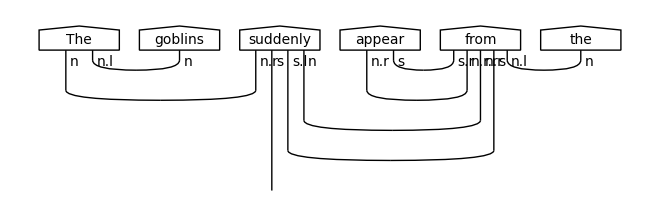

Target Circuit Performance Metrics: {'gate_depth': 41, 'gate_count': 180, 'execution_time_estimate': '18.000000000000004 ms'}

Generating circuit for the final hypothesis...


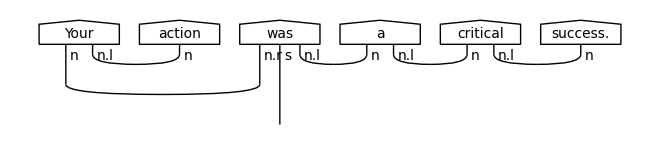

Hypothesis Circuit Performance Metrics: {'gate_depth': 33, 'gate_count': 86, 'execution_time_estimate': '8.6 ms'}

Comparison of Circuit Performance Metrics:
gate_depth_difference: 8
gate_count_difference: 94
execution_time_difference (ms): 9.400000000000004


In [58]:
import numpy as np
from pytket import Circuit
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit
import logging


logging.basicConfig(level=logging.INFO)

def rollDice():
    return np.random.randint(1, 21)

def generateQuantumCircuit(hypothesis, draw, optimize=True):
    try:
        logging.info("Parsing the hypothesis to quantum diagram...")
        diagram = lambeqParser.sentence2diagram(hypothesis)
        logging.info("Converting the diagram to quantum circuit...")
        circuit = quantumAnsatz(diagram)
        tketCircuit = circuit.to_tk()
        if optimize:
            optimized_params = optimize_parameters(tketCircuit)
            tketCircuit.symbol_substitution(optimized_params)
            logging.info(f"Optimized parameters: {optimized_params}")
        else:
            parameters = {sym: 0.5 for sym in tketCircuit.free_symbols()}
            tketCircuit.symbol_substitution(parameters)
            logging.info(f"Default parameters: {parameters}")
        logging.info("Compiling the circuit for the quantum backend...")
        compiledCircuit = quantumBackend.get_compiled_circuit(tketCircuit)
        if draw:
            logging.info("quantum diagram...")
            diagram.draw()
            logging.info("quantum circuit...")
            render_circuit_jupyter(tketCircuit)
        return compiledCircuit
    except Exception as e:
        logging.error("Error quantum circuit generation.", exc_info=True)
        return None

def optimize_parameters(circuit):
    params = list(circuit.free_symbols())
    optimized_values = {param: np.random.uniform(-1, 1) for param in params}
    return optimized_values

def generateZObservable(circuit):
    try:
        n = circuit.n_qubits
        observable_terms = {Qubit(i): Pauli.Z for i in range(n)}
        observable = QubitPauliOperator({QubitPauliString(observable_terms): 1.0})
        return observable
    except Exception as e:
        logging.error("Error observable generation.", exc_info=True)
        return None

def similarity(exp1, exp2, method='cosine'):
    try:
        if method == 'fidelity':
            return np.sum((np.sqrt(exp1) * np.sqrt(exp2)) ** 2)
        elif method == 'cosine':
            return np.dot(exp1, exp2) / (np.linalg.norm(exp1) * np.linalg.norm(exp2))
        else:
            raise ValueError(f"not in list: {method}")
    except Exception as e:
        logging.error("Error calculation.", exc_info=True)
        return None

def LAMBEQ(target, hypothesis, draw=False):
    tCirc = generateQuantumCircuit(target, draw)
    hCirc = generateQuantumCircuit(hypothesis, draw)
    if tCirc is None or hCirc is None:
        logging.error("Failed to generate circuits.")
        return None
    tOp = generateZObservable(tCirc)
    hOp = generateZObservable(hCirc)
    if tOp is None or hOp is None:
        logging.error("Failed for LAMBEQ calculation.")
        return None
    tExp = quantumBackend.get_operator_expectation_value(tCirc, tOp)
    hExp = quantumBackend.get_operator_expectation_value(hCirc, hOp)
    return similarity(tExp, hExp, method="cosine")

def evaluate_circuit_performance(circuit, gate_time=0.0001):
    try:
        depth = circuit.depth()
        gate_count = circuit.n_gates
        execution_time_estimate = gate_count * gate_time
        return {
            "gate_depth": depth,
            "gate_count": gate_count,
            "execution_time_estimate": f"{execution_time_estimate * 1e3} ms"
        }
    except Exception as e:
        logging.error("Error performance evaluation.", exc_info=True)
        return {}


draw = True
setting_prompt = """You are creating an interactive fiction game. Describe the initial setting and situation the player finds themselves in. Keep it to 2-3 sentences."""
model_inputs = tokenizer(setting_prompt, return_tensors="pt").to("cuda:0")
output = model.generate(**model_inputs, max_length=1024, temperature=0.7)
initial_situation = tokenizer.decode(output[0], skip_special_tokens=True).strip()
game_memory = [initial_situation]

print("\nWelcome to the AI Generated Adventure!")
print("\nYour situation:", initial_situation)

final_hypothesis = None
final_target = None
while True:
    print("\nWhat would you like to do? (type 'quit' to end)")
    action = input("> ")
    if action.lower() == 'quit':
        print("\nThanks for playing!")
        break

    dice_result = rollDice()
    response = generate_game_response(game_memory, action, dice_result, "prompt_file.txt")
    game_memory.append(response)
    print("\n" + response)
    target = ' '.join(response.split(' ')[:6])
    hypothesis = getActionHypothesis(dice_result)

    print('Target:\t\t', target)
    print('Hypothesis:\t', hypothesis)
    print('BLEU:\t\t', BLEU(target, hypothesis))
    print('ROUGE:\t\t', ROUGE(target, hypothesis))

    lambeq_score = LAMBEQ(target, hypothesis, draw=False)
    if lambeq_score is not None:
        print('LAMBEQ:\t\t', lambeq_score)
    else:
        print("LAMBEQ calculation failed.")
    final_hypothesis = hypothesis
    final_target = target

if final_hypothesis and final_target:
    print("\nFinal Target:\t", final_target)
    print("Final Hypothesis:", final_hypothesis)
    print("\nGenerating circuit for the final target...")
    target_circuit = generateQuantumCircuit(final_target, draw)
    if target_circuit:
        target_metrics = evaluate_circuit_performance(target_circuit)
        print(f"Target Circuit Performance Metrics: {target_metrics}")
    else:
        print("Failed to generate circuit for the final target.")
    print("\nGenerating circuit for the final hypothesis...")
    hypothesis_circuit = generateQuantumCircuit(final_hypothesis, draw)
    if hypothesis_circuit:
        hypothesis_metrics = evaluate_circuit_performance(hypothesis_circuit)
        print(f"Hypothesis Circuit Performance Metrics: {hypothesis_metrics}")
    else:
        print("Failed to generate circuit for the final hypothesis.")
    if target_circuit and hypothesis_circuit:
        print("\nComparison of Circuit Performance Metrics:")
        comparison = {
            "gate_depth_difference": abs(target_metrics["gate_depth"] - hypothesis_metrics["gate_depth"]),
            "gate_count_difference": abs(target_metrics["gate_count"] - hypothesis_metrics["gate_count"]),
            "execution_time_difference (ms)": abs(
                float(target_metrics["execution_time_estimate"].replace(" ms", ""))
                - float(hypothesis_metrics["execution_time_estimate"].replace(" ms", ""))
            ),
        }
        for key, value in comparison.items():
            print(f"{key}: {value}")
    else:
        print("Unable to compare circuits.")